# 05 - Device Monitoring & Fleet Management

**Author:** Hector Carbajal  
**Version:** 1.0  
**Last Updated:** 2026-02

---

## Purpose
This notebook implements **device-aware monitoring** that combines:
- **Risk scores**: ML predictions from the classifier
- **Fleet age**: Average device age for each firmware version
- **Monitoring tiers**: Immediate / Enhanced / Standard monitoring assignment

## Inputs
- `data/Processed/firmware_qa_priority.csv` - QA priority scores
- `test_patch_features.csv` - Device age data

## Outputs
- `data/Processed/monitoring_priority.csv` - Device monitoring assignments

## Monitoring Priority Weighting
- **70%** ML Risk Score
- **30%** Older Device Flag (devices > 600 days)

---

In [1]:
# [1] Setup, Imports, and Project Paths
# --------------------------------------------------------------------------
import os
from pathlib import Path
import numpy as np
import pandas as pd
import sys

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# Add project root to path
current_dir = Path.cwd()
project_root = current_dir.parents[0] if current_dir.name == "notebooks" else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import PROCESSED_DATA_DIR, PROJECT_ROOT

# For backward compatibility
DATA_DIR = PROCESSED_DATA_DIR

print(f"✅ Configuration loaded")
print(f"📁 Project root: {PROJECT_ROOT}")
print(f"📁 Data directory: {DATA_DIR}")

✅ Configuration loaded
📁 Project root: /Users/hc/Documents/projects/roku-patch-stability-analytics
📁 Data directory: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Processed


In [ ]:
# [2] Load Input Data and Enrich with Device Age
# --------------------------------------------------------------------------
# Input file is the output from the QA Prioritization notebook
input_file = DATA_DIR / "firmware_qa_priority.csv"

if not input_file.exists():
    raise FileNotFoundError(
        f"Input file not found at {input_file.resolve()}. \n"
        "Please ensure Notebook 04 (QA Prioritization) was run successfully."
    )

monitoring_df = pd.read_csv(input_file)

# Enrich with device age data from the original features file
# This enables device-aware monitoring prioritization
raw_features_file = PROJECT_ROOT / "test_patch_features.csv"
raw_df = pd.read_csv(raw_features_file)
raw_df.columns = raw_df.columns.str.strip()
age_data = raw_df[['firmware_version', 'avg_device_age_days']]

monitoring_df = monitoring_df.merge(
    age_data,
    on='firmware_version',
    how='left'
)

# Validate required columns are present
REQUIRED_COLS = ['risk_score', 'avg_device_age_days', 'firmware_version']
missing_cols = [col for col in REQUIRED_COLS if col not in monitoring_df.columns]

if missing_cols:
    raise KeyError(
        f"Missing required columns after merge: {missing_cols}. "
        "Check merge key ('firmware_version') and input file."
    )

print(f"✅ Input file loaded and enriched with device age. Shape: {monitoring_df.shape}")

In [ ]:
# [3] Calculate Monitoring Priority Score and Tier
# --------------------------------------------------------------------------

# --- 3a. Define Constants and Thresholds ---
# DEVICE_AGE_THRESHOLD: 600 days (~20 months) is based on:
#   - Typical consumer electronics refresh cycle (18-24 months)
#   - Increased failure rates in older devices due to wear
#   - End-of-support considerations for legacy firmware
DEVICE_AGE_THRESHOLD = 600  # days

# MONITORING_THRESHOLDS: Derived from operational capacity constraints
#   - Immediate (top 10%): Requires dedicated monitoring resources
#   - Enhanced (next 25%): Daily review cadence
#   - Standard (bottom 65%): Weekly review cadence
IMMEDIATE_MONITORING_THRESHOLD = 0.90  # Top 10% of composite scores
ENHANCED_MONITORING_THRESHOLD = 0.65   # Top 35% of composite scores

# --- 3b. Feature Engineering: Older Device Flag ---
monitoring_df['older_device_flag'] = (
    monitoring_df['avg_device_age_days'] >= DEVICE_AGE_THRESHOLD
).astype(int)

# --- 3c. Composite Score Calculation ---
# Weighting rationale:
#   - 70% Model Risk: ML predictions are the primary signal
#   - 30% Device Age: Secondary factor that amplifies risk for legacy devices
W_RISK = 0.70
W_AGE_FLAG = 0.30

monitoring_df['monitoring_priority'] = (
    W_RISK * monitoring_df['risk_score']
    + W_AGE_FLAG * monitoring_df['older_device_flag']
)

# --- 3d. Bucketing Function ---
def bucket_monitoring_tier(score):
    """Maps the composite score to an operational monitoring tier."""
    if score >= IMMEDIATE_MONITORING_THRESHOLD:
        return "Immediate Monitoring"
    elif score >= ENHANCED_MONITORING_THRESHOLD:
        return "Enhanced Monitoring"
    else:
        return "Standard Monitoring"

monitoring_df['monitoring_tier'] = monitoring_df['monitoring_priority'].apply(bucket_monitoring_tier)

print("✅ Monitoring Priority Scores calculated")
print(f"   Thresholds: Immediate >= {IMMEDIATE_MONITORING_THRESHOLD}, Enhanced >= {ENHANCED_MONITORING_THRESHOLD}")
print(f"   Device age threshold: {DEVICE_AGE_THRESHOLD} days")

In [4]:
# [4] Final Output and Reporting (Matching Notebook 04 Style)
# --------------------------------------------------------------------------

# 1. Define final output columns
FINAL_OUTPUT_COLS = [
    "firmware_version", 
    "risk_score", 
    "avg_device_age_days", 
    "older_device_flag", 
    "monitoring_priority", 
    "monitoring_tier"
]

final_monitoring_df = monitoring_df[FINAL_OUTPUT_COLS].sort_values(
    by="monitoring_priority", ascending=False
)

# 2. Export to CSV
output_path = DATA_DIR / "monitoring_priority.csv"
final_monitoring_df.to_csv(output_path, index=False)

# 3. Print Final Report
print(f"\n✅ Monitoring priority sheet generated and saved to: {output_path.name}")
print("\n--- Top 5 Monitoring Priorities (Recommendation #3) ---")
print(final_monitoring_df.head(5))


✅ Monitoring priority sheet generated and saved to: monitoring_priority.csv

--- Top 5 Monitoring Priorities (Recommendation #3) ---
    firmware_version  risk_score  avg_device_age_days  older_device_flag  monitoring_priority       monitoring_tier
162          10.37.1    0.974278           630.802832                  1             0.981995  Immediate Monitoring
223          10.51.0    0.968722           661.325724                  1             0.978106  Immediate Monitoring
483         10.105.2    0.967288           667.505742                  1             0.977101  Immediate Monitoring
125         10.27.13    0.967286           691.150590                  1             0.977100  Immediate Monitoring
670         10.143.3    0.966836           693.117585                  1             0.976785  Immediate Monitoring


## Validation Visualizations

/var/folders/k8/b8tgn5fj14n3g0d0vtpz6rcm0000gn/T/ipykernel_88895/2909012039.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=monitoring_df, x='monitoring_tier', y='risk_score',
/var/folders/k8/b8tgn5fj14n3g0d0vtpz6rcm0000gn/T/ipykernel_88895/2909012039.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=monitoring_df, x='monitoring_tier', y='monitoring_priority',


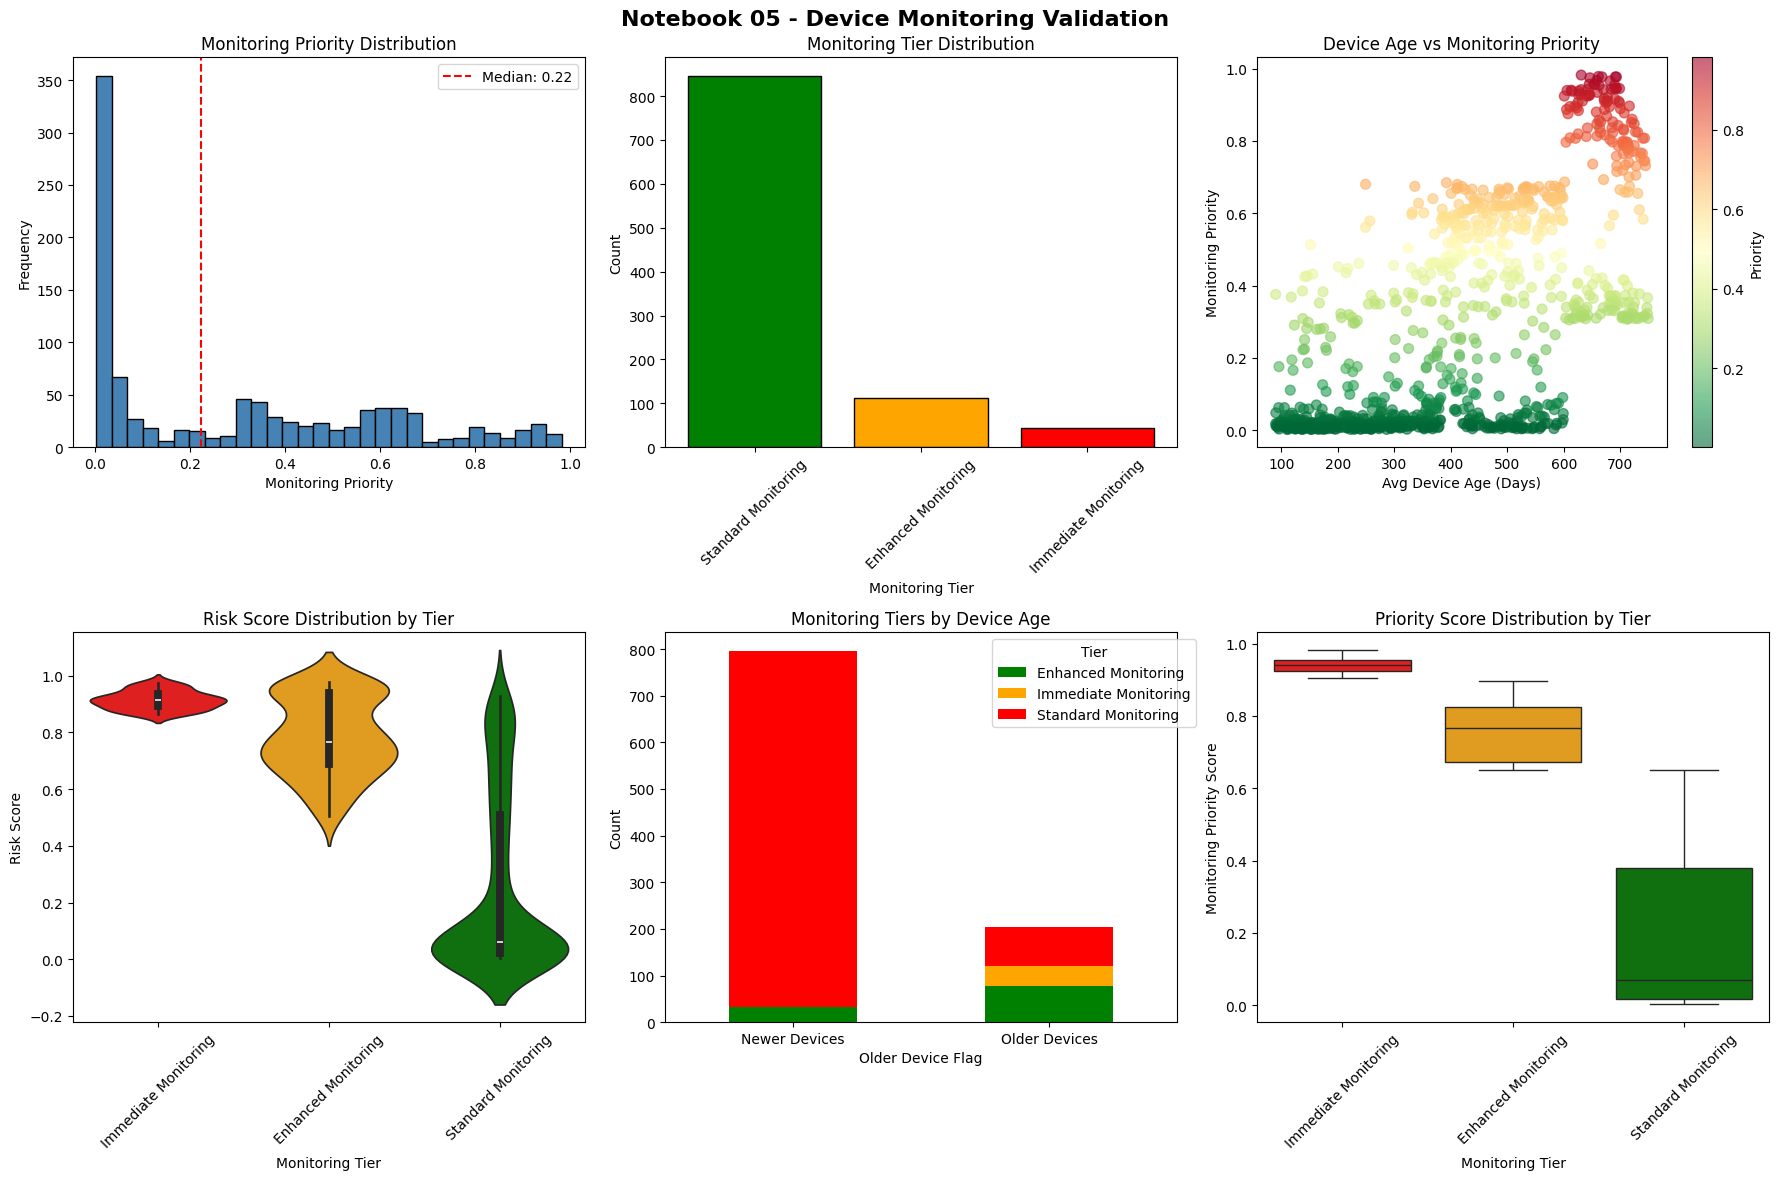


VALIDATION SUMMARY - Device Monitoring
Total devices monitored: 1000

Monitoring tier breakdown:
  Standard Monitoring: 846 (84.6%)
  Enhanced Monitoring: 111 (11.1%)
  Immediate Monitoring: 43 (4.3%)

Monitoring priority stats:
  Mean: 0.300
  Median: 0.224
  Std: 0.301
  Min: 0.002
  Max: 0.982

Device age stats:
  Mean age: 411.8 days
  Age range: [90, 749] days
  Devices over threshold (600 days): 204

Top 3 high-priority firmware versions:
  10.37.1 (Immediate Monitoring): priority=0.982, risk=0.974
  10.51.0 (Immediate Monitoring): priority=0.978, risk=0.969
  10.105.2 (Immediate Monitoring): priority=0.977, risk=0.967


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load device monitoring data for validation
monitoring_df = pd.read_csv(PROCESSED_DATA_DIR / "monitoring_priority.csv")

# Create comprehensive device monitoring validation visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Notebook 05 - Device Monitoring Validation', fontsize=16, fontweight='bold')

# 1. Monitoring priority score distribution
axes[0, 0].hist(monitoring_df['monitoring_priority'], bins=30, color='steelblue', edgecolor='black')
axes[0, 0].axvline(monitoring_df['monitoring_priority'].median(), color='red', 
                   linestyle='--', label=f'Median: {monitoring_df["monitoring_priority"].median():.2f}')
axes[0, 0].set_xlabel('Monitoring Priority')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Monitoring Priority Distribution')
axes[0, 0].legend()

# 2. Monitoring tier distribution
tier_counts = monitoring_df['monitoring_tier'].value_counts()
tier_colors = {'Immediate Monitoring': 'red', 'Enhanced Monitoring': 'orange', 'Standard Monitoring': 'green'}
colors = [tier_colors.get(tier, 'gray') for tier in tier_counts.index]
axes[0, 1].bar(tier_counts.index, tier_counts.values, color=colors, edgecolor='black')
axes[0, 1].set_xlabel('Monitoring Tier')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Monitoring Tier Distribution')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Device age vs monitoring priority
scatter = axes[0, 2].scatter(monitoring_df['avg_device_age_days'], 
                             monitoring_df['monitoring_priority'],
                             c=monitoring_df['monitoring_priority'], 
                             cmap='RdYlGn_r', s=50, alpha=0.6)
axes[0, 2].set_xlabel('Avg Device Age (Days)')
axes[0, 2].set_ylabel('Monitoring Priority')
axes[0, 2].set_title('Device Age vs Monitoring Priority')
plt.colorbar(scatter, ax=axes[0, 2], label='Priority')

# 4. Risk score distribution by monitoring tier
sns.violinplot(data=monitoring_df, x='monitoring_tier', y='risk_score',
               order=['Immediate Monitoring', 'Enhanced Monitoring', 'Standard Monitoring'],
               palette=tier_colors, ax=axes[1, 0])
axes[1, 0].set_xlabel('Monitoring Tier')
axes[1, 0].set_ylabel('Risk Score')
axes[1, 0].set_title('Risk Score Distribution by Tier')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Older device flag impact
tier_by_age = pd.crosstab(monitoring_df['older_device_flag'], 
                          monitoring_df['monitoring_tier'])
tier_by_age.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                color=['green', 'orange', 'red'])
axes[1, 1].set_xlabel('Older Device Flag')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Monitoring Tiers by Device Age')
axes[1, 1].legend(title='Tier', bbox_to_anchor=(1.05, 1))
# Set custom labels based on actual categories present
age_labels = []
for flag in tier_by_age.index:
    age_labels.append('Newer Devices' if flag == 0 else 'Older Devices')
axes[1, 1].set_xticklabels(age_labels, rotation=0)

# 6. Monitoring priority by tier (boxplot)
tier_order = ['Immediate Monitoring', 'Enhanced Monitoring', 'Standard Monitoring']
available_tiers = [t for t in tier_order if t in monitoring_df['monitoring_tier'].unique()]
sns.boxplot(data=monitoring_df, x='monitoring_tier', y='monitoring_priority', 
            order=available_tiers, palette=tier_colors, ax=axes[1, 2])
axes[1, 2].set_xlabel('Monitoring Tier')
axes[1, 2].set_ylabel('Monitoring Priority Score')
axes[1, 2].set_title('Priority Score Distribution by Tier')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print validation summary
print("\n" + "="*60)
print("VALIDATION SUMMARY - Device Monitoring")
print("="*60)
print(f"Total devices monitored: {len(monitoring_df)}")
print(f"\nMonitoring tier breakdown:")
for tier, count in tier_counts.items():
    print(f"  {tier}: {count} ({count/len(monitoring_df)*100:.1f}%)")
print(f"\nMonitoring priority stats:")
print(f"  Mean: {monitoring_df['monitoring_priority'].mean():.3f}")
print(f"  Median: {monitoring_df['monitoring_priority'].median():.3f}")
print(f"  Std: {monitoring_df['monitoring_priority'].std():.3f}")
print(f"  Min: {monitoring_df['monitoring_priority'].min():.3f}")
print(f"  Max: {monitoring_df['monitoring_priority'].max():.3f}")
print(f"\nDevice age stats:")
print(f"  Mean age: {monitoring_df['avg_device_age_days'].mean():.1f} days")
print(f"  Age range: [{monitoring_df['avg_device_age_days'].min():.0f}, {monitoring_df['avg_device_age_days'].max():.0f}] days")
print(f"  Devices over threshold ({600} days): {monitoring_df['older_device_flag'].sum()}")
print(f"\nTop 3 high-priority firmware versions:")
for idx, row in monitoring_df.nlargest(3, 'monitoring_priority').iterrows():
    print(f"  {row['firmware_version']} ({row['monitoring_tier']}): priority={row['monitoring_priority']:.3f}, risk={row['risk_score']:.3f}")
print("="*60)